# Tweet Sentiment Analysis Project

by Garrett Williams, Dave McKinley and Ely Lin of Sphinx Consulting

**Summary:**

For this project we used tweets gathered from a South by Southwest festival. Tweets provide insight into consumer sentiment. Consumers are more likely to purchase products when they have positive sentiments about a product, which in turn drives sales creating an opportunity for a better return on investment. To prepare this data for modeling we decided to utilize natural language processing techniques such as removing NLTK’s stopwords, mentions (@username), the hashtag symbol (#), hyperlinks, html formatting, and non-English characters and the two most popular words, “SXSW” and “link”. Furthermore, we transformed the words into lower case, lemmatized and tokenized the words to develop a more accurate accounting of words for analysis. To vectorize the data set for modeling we used Sci-Kit Learn’s Term Frequency, Inverse Document Frequency (TF-IDF) and CountVectorizer packages. For modeling techniques, we used Sci-Kit Learn’s Logistic Regression, with Primary Component Analysis(limits multicollinearity), Multinomial Naïve Bayes(good for text classification), Random Forest(more advanced algorithm) libraries and Keras’s Sequential neural network builder(Deep learning algorithm). We adjusted the max document frequency, min document frequency and max features hyperparameters for TF-IDF. We adjusted the Laplace smoothing alpha in the Multinomial Naïve Bayes Model. In the Neural Network, we added two hidden layers, two dropout sets and regularized the hidden layers’ weights, biases, and activation functions. We decided to use a TF-IDF tuned Multinomial Naïve Bayes Model because the model was not over fit and had a lower computational cost than the other models. The final model resulted in an accuracy score of 71.1% and a precision score of 71.8%.

## Overview

**Business Problem:**

In a world where technology startups are plentiful, consumer sentiment towards a brand can give us a lot of insights into their purchasing decisions, hence the financial performance of the company that makes them. Technology investment company WhiteOre have acquired our services to build them a predictive model that monitors recent tweets on technology products to help them make informed investment decisions. WhiteOre wants a generalizable model to gauge sentiment across different brands, to act as a filtering system to help decide which brands to investigate further for possible investment. WhiteOre only cares about whether people have positive emotions towards the brand because people buy things they like. 


**Target Audience:**

The hedge fund and private equity department of WhiteOre


**Data Understanding:**

The dataset comes from CrowdFlower via data.world. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither. The tweets included are sent out during the South by South West conference, mostly about Google and Apple products. The data was put together in 2013.

Tweets are usually short and packed with emotions. They can capture consumer's real time response to a brand very well. South by Southwest showcases all the newest technology and allows consumers to compare the products of major tech companies side by side, which can reduce their biases to some degree.

We engineered our target into two classes: tweets with positive sentiment and tweets without positive sentiment, which includes neutral, negative and indistinguishable sentiments. We only care about whether the tweet is positive because positive emotion drives sales, which can translate into return on investment. 

Data source: https://data.world/crowdflower/brands-and-product-emotions

**Context:**

False positive in this case would mean our model predicts that a consumer has positive emotions towards a brand but they actually don't, leading to overvaluing of a potential investment opportunity and wasting human capital.

False negative in this case would mean our model predicts that a consumer doesn't have positive emotions towards a brand but they actually do, leading to missing a potential investment opportunity.

**Metrics:**

We don't want to overvalue or undervalue a company, however, in the current market condition where labor cost and shortage is prominent, spending human resources to evaluate a company and finding out it's not worth investing in is more costly. Therefore, we care about maximizing accuracy as well as precision.


**Modeling**

We used nltk's TweetTokenizer and RegexpTokenizer to tokenize the tweets. We used count vectorizer and tfidf vectorizer to vectorize them. We limited our tfidf vectorizer features to reduce overfitting.

Modeling techniques include naive bayes, logistic regression, catboost and neural network. We also ran [decision trees](https://github.com/ElyLin/SentimentAnalysisProject/blob/main/notebooks/Ely/EDA-Ely.ipynb) and [random forest](https://github.com/ElyLin/SentimentAnalysisProject/blob/main/notebooks/Garrett/EDA-Garrett.ipynb) in our draft notebooks in group member's individual folder.

**Evaluation**

We are able to achieve 71% accuracy on both training data and testing data on both our naive bayes and neural network models without overfitting. However, naive bayes requires significantly less computational power so we decide to use naive bayes as our final model. 

## Data Understanding

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import RegexpTokenizer, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

from sklearn.model_selection import train_test_split, cross_validate
from numpy import array
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import regularizers, layers
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import Tokenizer

In [2]:
#load the dataset
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
#check the shape of the dataframe
df.shape

(9093, 3)

In [4]:
#rename columns for readability
df = df.rename(columns = {'tweet_text': 'Tweet', 
                         'emotion_in_tweet_is_directed_at': 'Product', 
                         'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'})
df.head() #Sanity Check

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [5]:
#looking at data, duplicates and null values
print(df.info())
print(("-"*20))
print('Total duplicated rows')
print(df.duplicated().sum())
print(("-"*20))
print('Total null values')
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      9092 non-null   object
 1   Product    3291 non-null   object
 2   Sentiment  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB
None
--------------------
Total duplicated rows
22
--------------------
Total null values
Tweet           1
Product      5802
Sentiment       0
dtype: int64


In [6]:
#Simplify sentiment labels for visualizations
dict_sent = {'No emotion toward brand or product':"No emotion", 
             'Positive emotion':'Positive emotion',
             'Negative emotion':'Negative emotion',
             "I can't tell": "I can't tell"}
df['Sentiment'] = df['Sentiment'].map(dict_sent)

In [7]:
#sentiment breakdown
df['Sentiment'].value_counts() 

No emotion          5389
Positive emotion    2978
Negative emotion     570
I can't tell         156
Name: Sentiment, dtype: int64

In [8]:
#number of tweets per product
df['Product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: Product, dtype: int64

In [9]:
#drop any NaN in the Tweet column
df['Tweet'].dropna(inplace=True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion
9091,Some Verizon iPhone customers complained their...,NaN,No emotion


In [10]:
#drop duplicates
df.drop_duplicates(inplace=True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion
9091,Some Verizon iPhone customers complained their...,NaN,No emotion


In [11]:
#drops Tweets with nonsensical characters
df.drop([6, 9092], inplace=True)

In [12]:
#reset the index after cleaning
df.reset_index(inplace=True)
df.drop(columns="index", inplace = True)

In [13]:
#looks at cleaned dataframe
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",NaN,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion
9067,"Google's Zeiger, a physician never reported po...",NaN,No emotion


In [14]:
#looks at remaining NaN's
print(df.isna().sum())

Tweet           0
Product      5787
Sentiment       0
dtype: int64


In [15]:
#Fills NaN's with "Undefined" to help with data visualizations
df['Product'].fillna("Undefined", inplace = True)
df

,Tweet,Product,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion


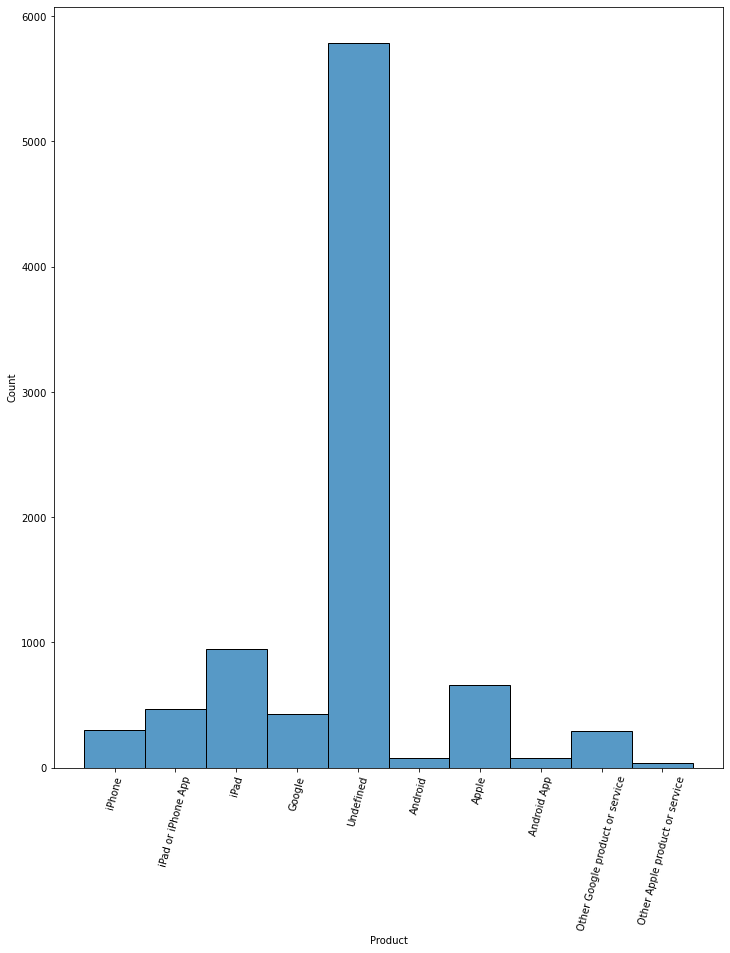

In [16]:
fig, ax = plt.subplots(figsize=(12,14))
sns.histplot(df["Product"] )
plt.xticks(rotation = 75)
plt.show()

There is a large imbalance between the undetermined products this may hinder analysis of product sentiment, however we can use this column to help us describe which brand the tweets are focused on.

In [17]:
#we are going to set the Product type as a string for our function below.
df["Product"].astype(str)

0                   iPhone
1       iPad or iPhone App
2                     iPad
3       iPad or iPhone App
4                   Google
               ...        
9064             Undefined
9065                  iPad
9066             Undefined
9067             Undefined
9068             Undefined
Name: Product, Length: 9069, dtype: object

The model is being built to gauge a brand's sentiment. Therefore we must look at a break down of different companies with in the dataset. The two brands in this data set happen to be two of the biggest tech brands in the world. Apple and Google. So we will create a new column to designate each tweet to a brand.

The code below was taken from https://github.com/srobz/Classifying-a-Tweet-s-Sentiment-Based-on-its-Content/blob/main/Phase%204%20Project%20-%201%20-%20Data%20Cleaning.ipynb

In [18]:
def find_brand(Product, Tweet):
    """
    This function is designed to take build a brand column based on the Product description. 
    After, the function will look at the Tweets and determine a brand for rows with no brand determined.
    
    Product -  a column teh function is working on
    Tweet - a column teh function is working on
    """
    brand = 'Undetermined' #Labeling brand as Undetermined
    if ((Product.lower().__contains__('google')) or (Product.lower().__contains__('android'))): #Labeling Google
        brand = 'Google' #Unless tweet contains google or android
    elif ((Product.lower().__contains__('apple')) or (Product.lower().__contains__('ip'))): #Labeling Apple
        brand = 'Apple' #Unless tweet contains apple or ip
    
    if (brand == 'Undetermined'): 
        lower_tweet = Tweet.lower() #Making tweet lowercase
        is_google = (lower_tweet.__contains__('google')) or (lower_tweet.__contains__('android')) #Undetermined google
        is_apple = (lower_tweet.__contains__('apple')) or (lower_tweet.__contains__('ip')) #Undetermined apple
        
        if (is_google and is_apple): #if it has both identifiers in the tweet
            brand = 'Both' #Labeling brand as both
        elif (is_google):
            brand = 'Google' #Labeling brand as Google
        elif (is_apple):
            brand = 'Apple' #Labeling brand as Apple
    
    return brand

df['Brand'] = df.apply(lambda x: find_brand(x['Product'], x['Tweet']), axis = 1) #Applying function to column
df['Brand'].value_counts() #Reviewing value counts of each class within brand

Apple           5361
Google          2756
Undetermined     739
Both             213
Name: Brand, dtype: int64

By creating a brand column, we can now analysis sentiment across brands without losing data. We keep the Undertermined and Both Brands to help train our models on realistic situations.

## Visualizing Data

In [19]:
#Sanity Check
df

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google
...,...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion,Google
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion,Google
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion,Google


In [20]:
def countplot(df, col, hue=None, rotation=None):
    """
    This function builds a Seaborn countplot and allows the user to set certain parameters to customize the graph.
    
    df - dataframe being used
    col- column in dataframe being used
    hue - second column being used(if any)
    rotation - sets the rotation of the x-ticks for readability
    """
    fig, ax = plt.subplots(figsize=(12,8))
    sns.countplot(data = df, x = col, hue = hue, order = df[col].value_counts().index)
    ax.set_xticklabels(labels = ax.get_xticklabels(), rotation= rotation, fontsize = 15)
    ax.set_xlabel(xlabel = col, fontsize = 20)
    ax.tick_params(axis='y', which='major', labelsize=15)
    ax.set_ylabel(ylabel = "Number of Tweets", fontsize = 20)
    ax.set_title(f"Number of Tweets per {col}", fontsize = 30)
    plt.show()

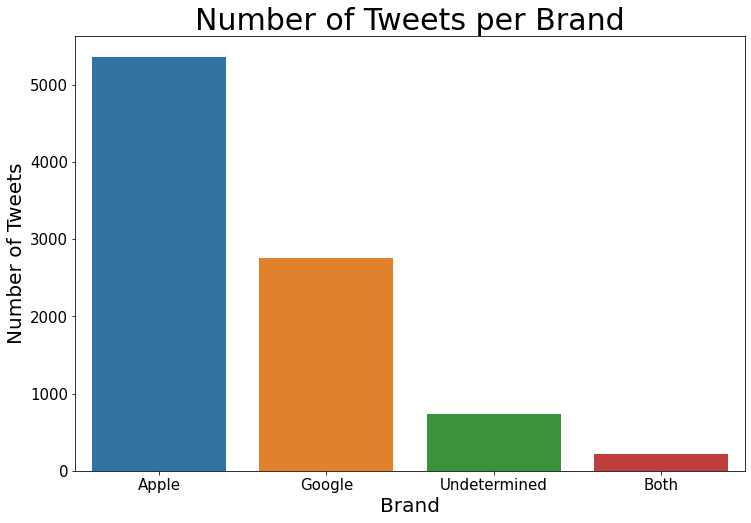

In [21]:
#countplot for Brand
countplot(df, "Brand")

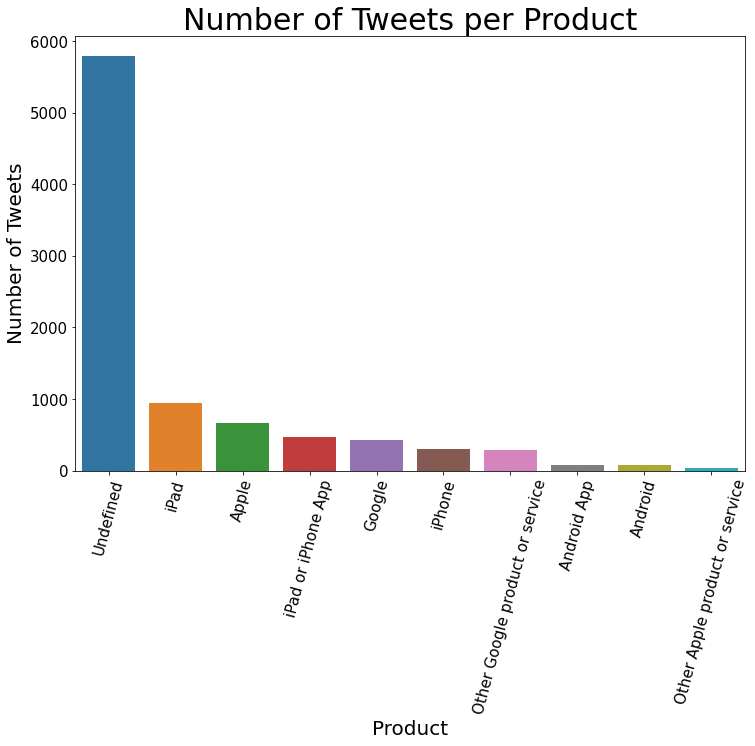

In [22]:
#countplot for Product
countplot(df, "Product", hue=None, rotation=75)

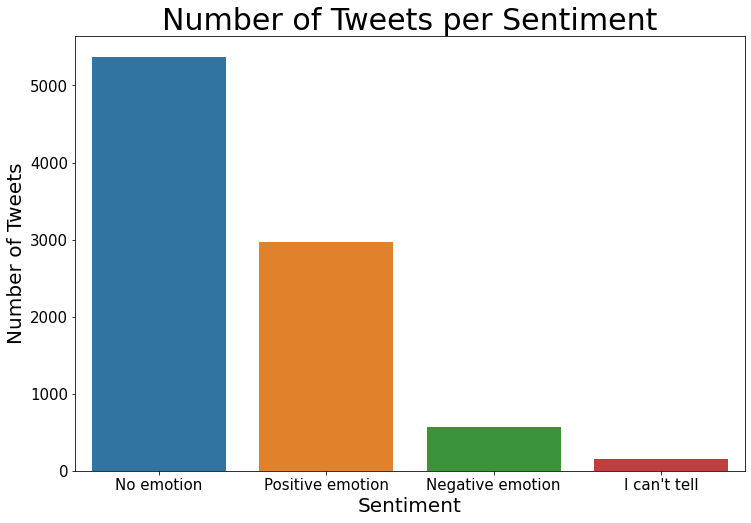

In [23]:
# Count plot for sentiment
countplot(df, "Sentiment")

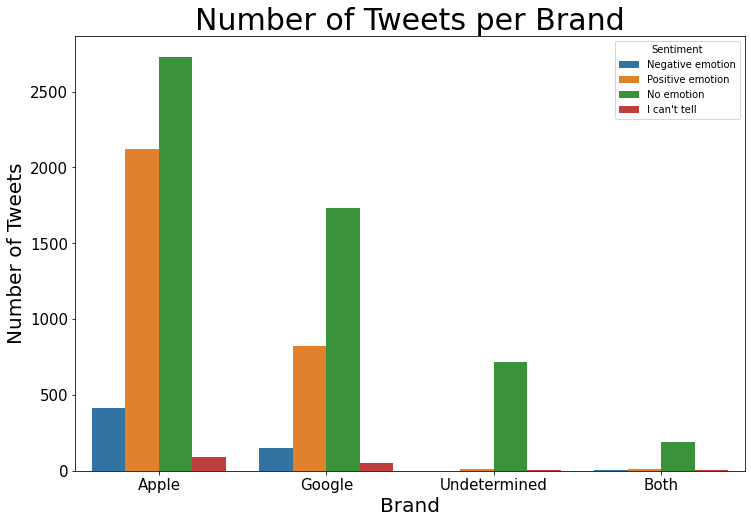

In [24]:
#count plot for Sentiment across brands
countplot(df, "Brand", hue = "Sentiment")

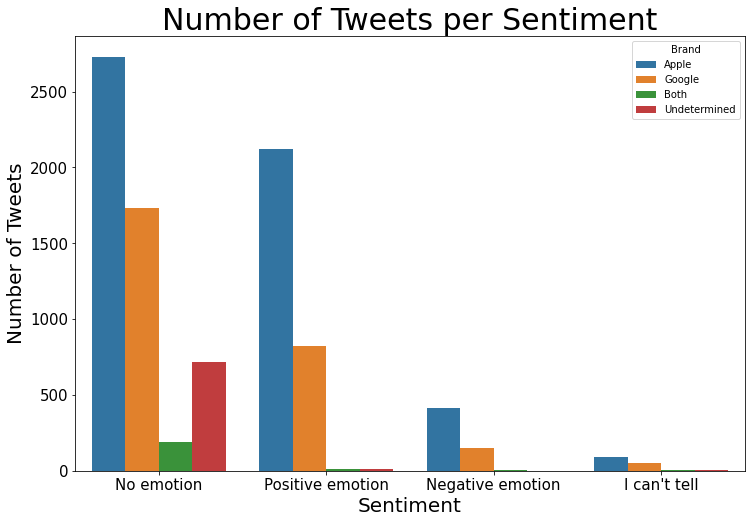

In [25]:
#countplot for brand make of sentiment
countplot(df, "Sentiment", hue="Brand")

In [26]:
#looking at the number of tweets per brand per sentiment
grouped = df.groupby(["Brand", "Sentiment"]).count()
grouped

Tweet  Product
Brand        Sentiment                       
Apple        I can't tell         93       93
             Negative emotion    415      415
             No emotion         2730     2730
             Positive emotion   2123     2123
Both         I can't tell          7        7
             Negative emotion      3        3
             No emotion          192      192
             Positive emotion     11       11
Google       I can't tell         50       50
             Negative emotion    150      150
             No emotion         1733     1733
             Positive emotion    823      823
Undetermined I can't tell          6        6
             Negative emotion      1        1
             No emotion          719      719
             Positive emotion     13       13

In [27]:
#looking at sentitmental breakdown of brands
display(df.groupby(['Sentiment'])['Brand'].value_counts(normalize = True))
print("-"*60)
display(df.groupby(['Brand'])['Sentiment'].value_counts(normalize = True))

Sentiment         Brand       
I can't tell      Apple           0.596154
                  Google          0.320513
                  Both            0.044872
                  Undetermined    0.038462
Negative emotion  Apple           0.729350
                  Google          0.263620
                  Both            0.005272
                  Undetermined    0.001757
No emotion        Apple           0.508001
                  Google          0.322479
                  Undetermined    0.133792
                  Both            0.035728
Positive emotion  Apple           0.714815
                  Google          0.277104
                  Undetermined    0.004377
                  Both            0.003704
Name: Brand, dtype: float64

------------------------------------------------------------


Brand         Sentiment       
Apple         No emotion          0.509233
              Positive emotion    0.396008
              Negative emotion    0.077411
              I can't tell        0.017348
Both          No emotion          0.901408
              Positive emotion    0.051643
              I can't tell        0.032864
              Negative emotion    0.014085
Google        No emotion          0.628810
              Positive emotion    0.298621
              Negative emotion    0.054427
              I can't tell        0.018142
Undetermined  No emotion          0.972936
              Positive emotion    0.017591
              I can't tell        0.008119
              Negative emotion    0.001353
Name: Sentiment, dtype: float64

In [28]:
#Number of Tweets per product
df["Product"].value_counts()

Undefined                          5787
iPad                                945
Apple                               659
iPad or iPhone App                  469
Google                              428
iPhone                              296
Other Google product or service     293
Android App                          80
Android                              77
Other Apple product or service       35
Name: Product, dtype: int64

In [29]:
#Number of Tweets per Sentiment
df["Sentiment"].value_counts()

No emotion          5374
Positive emotion    2970
Negative emotion     569
I can't tell         156
Name: Sentiment, dtype: int64

In [30]:
#Number of Tweet per Brand
df["Brand"].value_counts()

Apple           5361
Google          2756
Undetermined     739
Both             213
Name: Brand, dtype: int64

In [31]:
#Final DataFrame before Preprocessing
df

,Tweet,Product,Sentiment,Brand
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google
...,...,...,...,...
9064,"@mention Yup, but I don't have a third app yet...",Undefined,No emotion,Google
9065,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple
9066,"Wave, buzz... RT @mention We interrupt your re...",Undefined,No emotion,Google
9067,"Google's Zeiger, a physician never reported po...",Undefined,No emotion,Google


In [32]:
#Turn our Target into a Binary number
dict_sent = {'No emotion':0, 
             'Positive emotion':1,
             'Negative emotion':0,
             "I can't tell": 0}
df['Sentiment'] = df['Sentiment'].map(dict_sent)

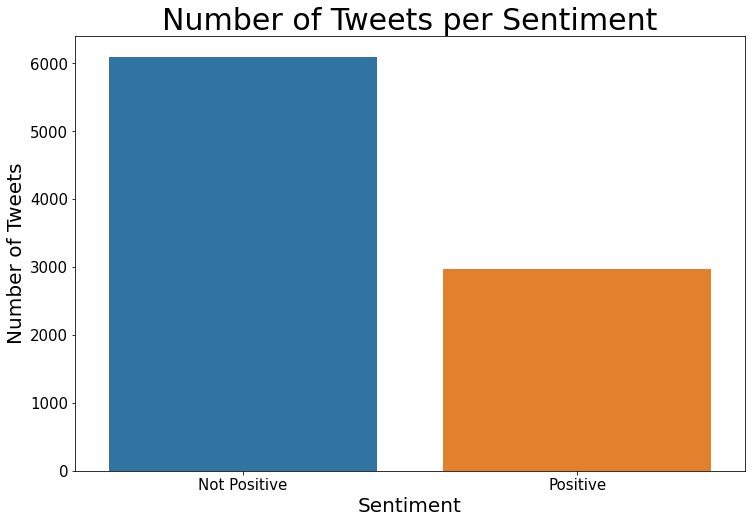

In [33]:
#Visualizing new Sentiment split
fig, ax = plt.subplots(figsize=(12,8))
sns.countplot(data = df, x = "Sentiment", order = df["Sentiment"].value_counts().index)
ax.set_xticklabels(labels = ["Not Positive", "Positive"], fontsize = 15)
ax.set_xlabel(xlabel = "Sentiment", fontsize = 20)
ax.tick_params(axis='y', which='major', labelsize=15)
ax.set_ylabel(ylabel = "Number of Tweets", fontsize = 20)
ax.set_title(f"Number of Tweets per Sentiment", fontsize = 30)
plt.show()

Doing the train-test split before the Data Preprocessing prevents data leakage.

In [34]:
#Create the X DataFrame with only the tweets
X = df[['Tweet']]
#Create the y Series with only the sentiments, 1 for Positive, 0 for not Positive
y = df['Sentiment']
#First train test split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

#Second train test split
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=42)

In [35]:
#Check first few rows in X_train
X_train.head()

,Tweet
2320,@mention Can we make you an iPhone case with T...
5622,RT @mention Come party down with @mention &amp...
1748,#winning #winning - just gave away 5 red mophi...
5789,RT @mention google &amp; facebook have an offi...
3334,Rumor of Google launching their new social net...


In [36]:
#Check how many rows X_train has
X_train.shape

(6121, 1)

## Data Preprocessing

**Cleaning up tweets:**

Remove: 
- words shorter than 3 characters
- stop words
- all forms of "SXSW" because it's in a large number of tweets therefore it has no value
- "link" and "video" because they are placeholders for a link
- http/www websites and html formating 
- punctuation and signs
- non english characters

Lowercase all words

Tokenize

Lemmatize

In [37]:
#Instantiate necessary tools
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
stopwords_list = stopwords.words("english")
stopwords_list.append("sxsw") #remove sxsw because it's the hashtag for the event
stopwords_list.append("link")
lemma = WordNetLemmatizer()
tweet_tknzr = TweetTokenizer(strip_handles=True)

In [38]:
def clean_tweets(text):
    """
    This function takes a tweet and preprocesses it for modeling
    """
    #Use TweetTokenizer object to remove the handles from the Tweet
    #TweetTokenizer also puts each punctuation as it's own token
    no_handle = tweet_tknzr.tokenize(text)
    #Join the list of non-handle tokens back together
    tweet = " ".join(no_handle) 
    #remove http websites, hashtag sign, any words in curly brackets,
        #any words with ampersand in front, www dot com websites, links,
        #videos, and non-english characters
    clean = re.sub("(https?:\/\/\S+) \
                   |(#[A-Za-z0-9_]+) \
                   |(\{([a-zA-Z].+)\}) \
                   |(&[a-z]+;) \
                   |(www\.[a-z]?\.?(com)+|[a-z]+\.(com))\
                   |({link})\
                   |(\[video\])\
                   |([^\x00-\x7F]+\ *(?:[^\x00-\x7F]| )*)"," ", tweet)
    #Turn all the tokens lowercase
    lower = clean.lower()
    #Only include words with 3 or more characters
    token_list = tokenizer.tokenize(lower)
    #Remove stopwords
    stopwords_removed=[token for token in token_list if token not in stopwords_list]
    #Lemmatize the remaining word tokens
    lemma_list = [lemma.lemmatize(token) for token in stopwords_removed]
    #Turn the lemma list into a string for the Vectorizer
    cleaned_string = " ".join(lemma_list) 
    return cleaned_string

In [39]:
#Sanity Check
clean_tweets(X_train['Tweet'].iloc[5622])

'new ubersocial iphone app store includes uberguide sponsored mashable'

In [40]:
#Apply our clean_tweets function to X_train, X_val
X_train['Tweet'] = X_train['Tweet'].apply(lambda x: clean_tweets(x))
X_val['Tweet'] = X_val['Tweet'].apply(lambda x: clean_tweets(x))

C:\Users\david\AppData\Local\Temp/ipykernel_68412/4144325319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Tweet'] = X_train['Tweet'].apply(lambda x: clean_tweets(x))
C:\Users\david\AppData\Local\Temp/ipykernel_68412/4144325319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['Tweet'] = X_val['Tweet'].apply(lambda x: clean_tweets(x))


In [41]:
#Sanity Check
X_train

,Tweet
2320,make iphone case ttye time want show support
5622,come party google tonight band food art intera...
1748,winning winning gave away red mophie juice pac...
5789,google facebook official death policy vast maj...
3334,rumor google launching new social network call...
...,...
5692,even security guard austin enjoy ipad time
8582,attending want explore austin check austin via
7815,apple popup store gonnagetanipad2
7483,putting pop apple store smart talk understandi...


In [42]:
y_train

2320    0
5622    1
1748    0
5789    0
3334    0
       ..
5692    1
8582    0
7815    0
7483    1
3531    0
Name: Sentiment, Length: 6121, dtype: int64

In [43]:
X_val

,Tweet
888,hootsuite mobile update iphone blackberry andr...
4191,morning hearing google circle today
2161,great location choice nice timing ipad launch ...
1882,win ipad via
4693,launching product plenty else join h4ckers 80 ...
...,...
1030,racing around best fueling great local fare ea...
4179,omg still line new ipad dieing hunger else line
7714,hour popup apple store lone security guard enj...
8190,great app interface example moma target flipbo...


In [44]:
y_val

888     0
4191    0
2161    1
1882    1
4693    0
       ..
1030    0
4179    1
7714    0
8190    1
4510    0
Name: Sentiment, Length: 2041, dtype: int64

## Modeling

### Baseline Understanding

In [45]:
#Baseline Understanding
y_train.value_counts(normalize=True)

0    0.67636
1    0.32364
Name: Sentiment, dtype: float64

If we predict all outcomes to be the majority class, we will be correct 67.6% of the time.

### 1st Iteration: Simple Naive Bayes

For our first model, we ran an untuned naive bayes model because after cleaning up stop words, we can safely assume the words are independent of each other. The model is simple and good with large datasets. We used multinomial naive bayes because it is used for discrete counts.

In [46]:
#Create a pipeline to use an Untuned TfidfVectorizer() and MultinomialNB()
pipe_nb = Pipeline(steps=[
    ('tfidf_vectorizer', TfidfVectorizer()),
    ('nb', MultinomialNB())
])
#Cross validate
cv_nb = cross_validate(pipe_nb, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
#See the results
cv_nb

{'fit_time': array([0.19902039, 0.23702192, 0.21975112, 0.20901632, 0.15401459]),
 'score_time': array([0.11570358, 0.10900688, 0.11400962, 0.12400746, 0.04899955]),
 'test_accuracy': array([0.7077551 , 0.70588235, 0.69934641, 0.69526144, 0.71078431]),
 'train_accuracy': array([0.7871732 , 0.79620176, 0.78701246, 0.79497652, 0.79170921]),
 'test_recall': array([0.15869018, 0.1540404 , 0.12878788, 0.13888889, 0.16414141]),
 'train_recall': array([0.35858586, 0.38611987, 0.35772871, 0.38044164, 0.37097792]),
 'test_roc_auc': array([0.73128324, 0.67639255, 0.6935051 , 0.70312119, 0.69988075]),
 'train_roc_auc': array([0.89107409, 0.89927336, 0.89339463, 0.89676999, 0.89251112])}

In [47]:
#Get mean accuracy for train
cv_nb['train_accuracy'].mean()

0.7914146282704764

In [48]:
#Get mean accuracy for test
cv_nb['test_accuracy'].mean()

0.7038059223689477

Training accuracy is much higher than testing accuracy, the model is overfitted.

In [49]:
# fit training data to simple naive bayes
pipe_nb.fit(X_train["Tweet"], y_train)

Pipeline(steps=[('tfidf_vectorizer', TfidfVectorizer()),
                ('nb', MultinomialNB())])

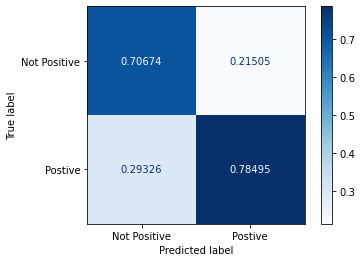

In [50]:
# plot confusion matrix
plot_confusion_matrix(pipe_nb, X_val["Tweet"], y_val, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "pred")

In [51]:
pipe_nb.score(X_train['Tweet'],y_train)

0.7912105865054729

In [52]:
pipe_nb.score(X_val['Tweet'],y_val)

0.7138657520823126

Accuracy score on validation set is very similar to cross validation test sets, the model is overfitted. Precision score is 78.5%.

### 2nd Iteration: Naive Bayes with a tuned TfidfVectorizer

We tuned these hyperparameters using gridsearch. For our tfidf vectorizer, we are only taking the top 1000 words while ignoring words that appear in more than 99% of the tweets (max_df=.99) and words that appear in less than 0.3% of the tweets.
The alpha level of 0.1 prevents our model from losing data.

In [53]:
#Create a pipeline to use an Tuned TfidfVectorizer() and MultinomialNB()
pipe_nb_tuned = Pipeline(steps=[
    ('tfidf_vectorizer_tuned', TfidfVectorizer(max_df=.99,min_df=0.003, max_features=1000)),
    ('nb_tuned', MultinomialNB(alpha=.1))
])
#Cross validate
cv_nb_tuned = cross_validate(pipe_nb_tuned, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])
#See the results
cv_nb_tuned

{'fit_time': array([0.66344285, 0.23701835, 0.21401358, 0.23701835, 0.25601268]),
 'score_time': array([0.07100725, 0.12701511, 0.12201095, 0.11100602, 0.11667991]),
 'test_accuracy': array([0.72734694, 0.70506536, 0.72385621, 0.69281046, 0.71323529]),
 'train_accuracy': array([0.73794935, 0.74351644, 0.73126404, 0.74331223, 0.73330611]),
 'test_recall': array([0.25692695, 0.23989899, 0.25252525, 0.23232323, 0.22474747]),
 'train_recall': array([0.2979798 , 0.31798107, 0.26876972, 0.31167192, 0.28391167]),
 'test_roc_auc': array([0.71212992, 0.67295692, 0.68672687, 0.67799066, 0.67756216]),
 'train_roc_auc': array([0.76357295, 0.77033338, 0.76427321, 0.7672572 , 0.7678182 ])}

In [54]:
#Get mean accuracy for train
cv_nb_tuned['train_accuracy'].mean()

0.7378696324013234

In [55]:
#Get mean accuracy for test
cv_nb_tuned['test_accuracy'].mean()

0.7124628518073897

In [56]:
#fit tuned naive bayes on training data
pipe_nb_tuned.fit(X_train["Tweet"], y_train)

Pipeline(steps=[('tfidf_vectorizer_tuned',
                 TfidfVectorizer(max_df=0.99, max_features=1000, min_df=0.003)),
                ('nb_tuned', MultinomialNB(alpha=0.1))])

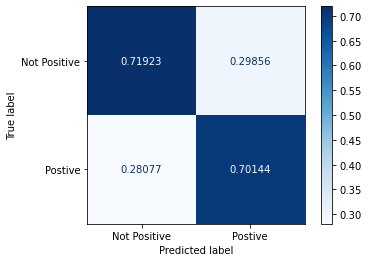

In [57]:
# plot confusion matrix that shows the precision score
plot_confusion_matrix(pipe_nb_tuned, X_val["Tweet"], y_val, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "pred")

In [58]:
pipe_nb_tuned.score(X_train['Tweet'],y_train)

0.7353373631759517

In [59]:
pipe_nb_tuned.score(X_val['Tweet'],y_val)

0.7168054875061245

Our validation set accuracy is higher than our last model. The difference between training set accuracy and validation set accuracy is very small. The model is not overfitted.

### 3rd Iteration: Logistic Regression with PCA

We also tried logistic regression. We added a PCA because it removes multicollinearity and reduces dimensions. Before we can use PCA, we have to scale the vectorized data.

In [60]:
#Create a tuned tfidf vectorizer that will be scaled for PCA
tfidf_vectorizer_tuned = TfidfVectorizer(max_df=.99,min_df=0.005, max_features=1000)

#Fit vectorizer on X_train
tfidf_vectorizer_tuned.fit(X_train['Tweet'])

#Transform X_train and X_val
X_train_tfidf_vec = tfidf_vectorizer_tuned.transform(X_train['Tweet'])
X_val_tfidf_vec = tfidf_vectorizer_tuned.transform(X_val['Tweet'])

#Turn X_train and X_val into DataFrame
X_train_tfidf_vec_df = pd.DataFrame(X_train_tfidf_vec.toarray())
X_val_tfidf_vec_df = pd.DataFrame(X_val_tfidf_vec.toarray())

In [61]:
#Create a StandardScaler Object
scaler = StandardScaler()

#Fit scaler to tuned vectorized X_train and transform both X_train and X_val
X_train_scaled = scaler.fit_transform(X_train_tfidf_vec_df)
X_val_scaled = scaler.transform(X_val_tfidf_vec_df)

In [62]:
#Create a PCA object
pca = PCA(n_components = .99, random_state=42)

In [63]:
#Create a Pipeline object for PCA and Logistic Regression
pipe_lr = Pipeline([('pca', pca), 
                    ('lr', LogisticRegression(random_state=42, max_iter=1000))])
pipe_lr.fit(X_train_scaled, y_train)

Pipeline(steps=[('pca', PCA(n_components=0.99, random_state=42)),
                ('lr', LogisticRegression(max_iter=1000, random_state=42))])

In [64]:
#Check results
print("PCA with n_components=0.99, tuned tfidf vectorizer, and logistic regression model")
print('Training set accuracy')
print(pipe_lr.score(X_train_scaled, y_train))
print('Validation set accuracy')
print(pipe_lr.score(X_val_scaled, y_val))

PCA with n_components=0.99, tuned tfidf vectorizer, and logistic regression model
Training set accuracy
0.7221042313347492
Validation set accuracy
0.7070063694267515


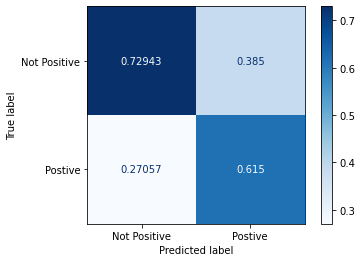

In [65]:
plot_confusion_matrix(pipe_lr, X_val_scaled, y_val, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "pred")

This model is not overfitted but the accuracy is lower than our tuned naive bayes model. The precision score is significantly lower.

### 4th Iteration: CatBoost

CatBoost is a sophisticated model based on random forest. It tends to be less overfitting than random forest. We used a tuned tfidf again to reduce overfitting.

In [66]:
#Create a pipeline with CatBoost
pipe_cbc = Pipeline(steps=[
    ('tfidf_vectorizer', TfidfVectorizer(max_df=.99,min_df=0.0005, max_features=1000)),
    ('cbc', CatBoostClassifier(silent=True))
])
#Cross Validate
cv_cbc = cross_validate(pipe_cbc, X_train['Tweet'], y_train, return_train_score=True, \
                    scoring=['accuracy', 'recall','roc_auc'])

In [67]:
#Get mean accuracy for train
cv_cbc['train_accuracy'].mean()

0.7953354544799337

In [68]:
#Get mean accuracy for test
cv_cbc['test_accuracy'].mean()

0.7234101640656263

In [69]:
# fit model to training set
pipe_cbc.fit(X_train["Tweet"], y_train)

Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_df=0.99, max_features=1000,
                                 min_df=0.0005)),
                ('cbc',
                 <catboost.core.CatBoostClassifier object at 0x000001E8D3D10C40>)])

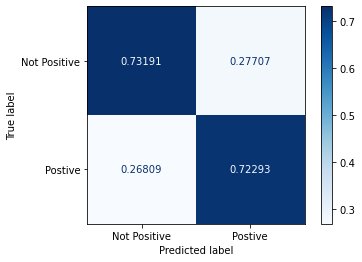

In [70]:
plot_confusion_matrix(pipe_cbc, X_val["Tweet"], y_val, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "pred")

In [71]:
print('Training set accuracy')
print(pipe_cbc.score(X_train['Tweet'], y_train))
print('Validation set accuracy')
print(pipe_cbc.score(X_val['Tweet'], y_val))

Training set accuracy
0.7990524424113707
Validation set accuracy
0.7305242528172464


Training accuracy is much higher than validation accuracy, the model is overfitted.

### 5th Iteration: Neural Network with Regularization

We chose two hidden layers and two dropout sets to better train the model but not overfit to the data. Additionally, we included ridge regression regularizers to the hidden layers' weights, biases and activation functions to reduce overfitting.

In [72]:
# Sets the sets as a Series Object in order to run on a neural network
X_train = X_train["Tweet"]
X_val = X_val["Tweet"]

In [73]:
#Sanity Check
print(type(X_train))
print(type(X_val))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [74]:
#How long is our longest tweet for padding
max_length = max([len(tweet.split()) for tweet in X_train])
max_length

18

In [75]:
# Instatiate the Tokenizer
k_tokenizer = keras.preprocessing.text.Tokenizer()

#fit the tokenizer
k_tokenizer.fit_on_texts(X_train)

#tokenizing text
X_train_token = k_tokenizer.texts_to_sequences(X_train)
X_val_token = k_tokenizer.texts_to_sequences(X_val)

In [76]:
#pads the tweets for equal length
X_train_processed = keras.preprocessing.sequence.pad_sequences(
    X_train_token, maxlen=max_length, padding='post')
X_val_processed = keras.preprocessing.sequence.pad_sequences(
    X_val_token, maxlen=max_length, padding='post')

In [77]:
#checks word length list
vocab_size = len(k_tokenizer.word_index) + 1
maxlen= 100
print(vocab_size)

7137


Following Function can be found here : https://github.com/flatiron-school/DSLE-083021-Phase4-NN-Review

In [78]:
def create_embedding_matrix(glove_filepath, word_index, embedding_dim):
    '''
    
    Grabs the embeddings just for the words in our vocabulary
    
    Inputs:
    glove_filepath - string, location of the glove text file to use
    word_index - word_index attribute from the keras tokenizer
    embedding_dim - int, number of dimensions to embed, a hyperparameter
    
    Output:
    embedding_matrix - numpy array of embeddings
    '''
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(glove_filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

GloVE file is too large for Git Hub, can be found here: https://nlp.stanford.edu/projects/glove/

In [79]:
#sets the embedding dimensions
embedding_dim = 50
embedding_matrix = create_embedding_matrix('notebooks/dave/glove.6B.50d.txt',
                                           k_tokenizer.word_index, 
                                           embedding_dim)

In [80]:
#instantiate neural network
model = keras.models.Sequential()
#set embedding for the input layer
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=max_length, 
                           trainable=True))
# flattening these layers down before connecting to dense layer
model.add(layers.Flatten())
# randomly drops out half of hidden layer nodes to regularize model
model.add(Dropout(0.5))
# adds the first hidden layer with ridge regression regularizer to the weights, biases and activation functions
model.add(layers.Dense(350, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(l2=1e-3),
                       bias_regularizer=regularizers.l2(1e-3),
                      activity_regularizer=regularizers.l2(1e-3)))
# randomly drops out half of hidden layer nodes to regularize model
model.add(Dropout(0.5))
# adds the second hidden layer with ridge regression regularizer to the weights, biases and activation functions
model.add(layers.Dense(350, activation='sigmoid',
                       kernel_regularizer=regularizers.l2(l2=1e-3),
                       bias_regularizer=regularizers.l2(1e-3),
                      activity_regularizer=regularizers.l2(1e-3)))
# adds the output layer
model.add(layers.Dense(1, activation='sigmoid'))
# compiles the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 18, 50)            356850    
_________________________________________________________________
flatten (Flatten)            (None, 900)               0         
_________________________________________________________________
dropout (Dropout)            (None, 900)               0         
_________________________________________________________________
dense (Dense)                (None, 350)               315350    
_________________________________________________________________
dropout_1 (Dropout)          (None, 350)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 350)               122850    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3

In [81]:
# fits the model
history = model.fit(X_train_processed, y_train, 
                    batch_size=50, 
                    epochs=10, 
                    validation_data=(X_val_processed, y_val))

Epoch 1/10
123/123 [==============================] - 4s 29ms/step - loss: 1.1620 - accuracy: 0.6682 - val_loss: 0.9198 - val_accuracy: 0.6619
Epoch 2/10
123/123 [==============================] - 3s 22ms/step - loss: 0.8453 - accuracy: 0.6796 - val_loss: 0.7944 - val_accuracy: 0.6624
Epoch 3/10
123/123 [==============================] - 3s 21ms/step - loss: 0.7657 - accuracy: 0.6916 - val_loss: 0.7378 - val_accuracy: 0.6820
Epoch 4/10
123/123 [==============================] - 3s 21ms/step - loss: 0.7204 - accuracy: 0.7041 - val_loss: 0.7104 - val_accuracy: 0.6948
Epoch 5/10
123/123 [==============================] - 3s 20ms/step - loss: 0.6962 - accuracy: 0.7139 - val_loss: 0.7060 - val_accuracy: 0.7095
Epoch 6/10
123/123 [==============================] - 3s 21ms/step - loss: 0.6785 - accuracy: 0.7303 - val_loss: 0.7247 - val_accuracy: 0.6737
Epoch 7/10
123/123 [==============================] - 3s 21ms/step - loss: 0.6591 - accuracy: 0.7458 - val_loss: 0.6889 - val_accuracy: 0.7256

In [82]:
# function for visualizing neural network training history
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

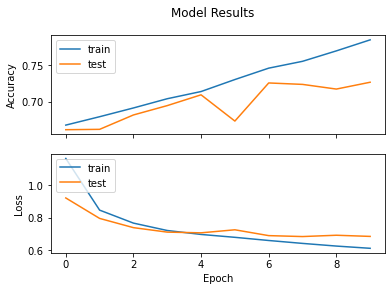

In [83]:
# visualizes training history
visualize_training_results(history)

The model is good, but not much better than our naive bayes model, which requires less computational power. Therefore we are going with the naive bayes model with the tuned tfidf vectorizer.

## Evaluation

In [60]:
# print out test set
X_test

,Tweet
5278,RT @mention #SXSW Come see Bitbop in Austin #g...
8080,12 #SXSW startup's elevator pitches in 12 minu...
6599,RT @mention RT @mention We interrupt your regu...
8206,Didn't get enough hacking on #startupbus? RSVP...
5244,RT @mention #Social Is Too Important For #Goog...
...,...
5883,RT @mention Google to Launch Major New Social ...
5710,RT @mention First day the exhibit hall is open...
637,Catch 22Û_ I mean iPad 2 at #SXSW - {link} #a...
3064,I21: No Rest for the Wicked {link} [codes vali...


In [61]:
# clean X_test 
X_test['Tweet'] = X_test['Tweet'].apply(lambda x: clean_tweets(x))

C:\Users\david\AppData\Local\Temp/ipykernel_68412/3177860538.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Tweet'] = X_test['Tweet'].apply(lambda x: clean_tweets(x))


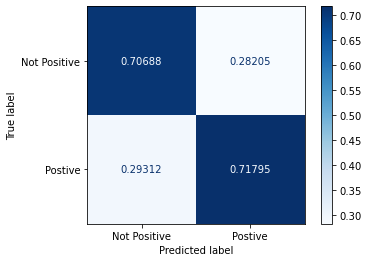

In [62]:
plot_confusion_matrix(pipe_nb_tuned, X_test["Tweet"], y_test, values_format='.5g', cmap=plt.cm.Blues, 
                      display_labels=["Not Positive", "Postive"], normalize = "pred")

In [63]:
# print score for test set
pipe_nb_tuned.score(X_test["Tweet"], y_test)

0.7078280044101434

In [64]:
# print score for train set
pipe_nb_tuned.score(X_train['Tweet'],y_train)

0.7353373631759517

In [65]:
# print score for validation set
pipe_nb_tuned.score(X_val['Tweet'],y_val)

0.7168054875061245

The testing score is roughly the same as our training and validation set, the model is not overfitted.

## Conclusion

### Result

Our naive bayes model with an alpha level of 0.1.
Our TfidfVectorizer has a max_df of 0.99, min_df of 0.003 and max_features of 1000 words.
The model's accuracy on test set is 71.1%.
The model's precision is 71.8%, which means out of all the tweets the model classifies as of positive sentiment, 71.8% of them are actually of positive sentiment.

We chose this model because it achieves the same level of accuracy as the neural network model without overfitting, however, naive bayes model requires a lot less computational power.

### Deployment

To put this model to work, WhiteOre would need to take these steps:

- Target the tech companies to investigate since the model is trained on tweets about Apple and Google 
- Scrape tweets about these companies and run them through the model
- Decide the threshold of positive sentiment of a company that WhiteOre would be willing to investigate
- Put man power in the companies that are above the threshold 

### Next steps for Improvement

- Explore more ways to clean the tweet data and see how they affect the model

- Scrape and train on recent tweets because our dataset is from 2013 and technology is constantly evolving

- Potentially add in tweets about other sectors to make the model more generalizable
